# 🚀 The Semantic Gap: Why Cross-Modal Metric Learning Fails on Face and Fingerprint Fusion

## 1. Introduction & The Hypothesis
In this notebook, we conducted an experiment using the **Face-Fingerprint Dataset** (14,780 paired images). Our primary goal was to investigate whether a deep learning model could learn a **Shared Embedding Space** between two entirely different biometric modalities: faces and fingerprints.

**The Hypothesis:** By using a Siamese-like Dual ResNet architecture and applying **Contrastive Loss**, we attempt to map a person's face and fingerprint into the same 256-dimensional vector space. The theory is that the model will push the embeddings of the *same person's* face and fingerprint closer together ($L2$ distance approaching 0), while pushing *different people's* biometrics apart (distance approaching our margin of 2.0). Let's see if deep learning can bridge the gap.

In [1]:
# ==========================================
# 1. IMPORTS & DEVICE SETUP
# ==========================================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. The Biological Reality & Data Preparation
Unlike matching two faces under different lighting, matching a face to a fingerprint is a completely **cross-modal** task. Biological reality dictates that **there is no visual or genetic correlation between the shape of a person's face and the minutiae patterns on their fingerprints**. 

To test if a neural network can find a hidden correlation anyway, we construct a dataset generator that feeds the model 50% Positive Pairs (same identity) and 50% Negative Pairs (different identities). We strictly split the dataset by identity to prevent data leakage.

In [2]:
# ==========================================
# 2. DATA PREPARATION & DATALOADER
# ==========================================
DATA_DIR = "/kaggle/input/face-fingerprint-dataset" 
FACE_DIR = os.path.join(DATA_DIR, "face")
FINGER_DIR = os.path.join(DATA_DIR, "fingerprint")

BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.0001
EMBEDDING_DIM = 256
MARGIN = 2.0

# 80/20 Strict Identity Split
all_files = sorted(os.listdir(FACE_DIR))
random.seed(42)
random.shuffle(all_files)

train_split = int(len(all_files) * 0.8)
train_files = all_files[:train_split]
test_files = all_files[train_split:]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class SharedSpaceDataset(Dataset):
    def __init__(self, face_dir, finger_dir, file_list, transform=None):
        self.face_dir = face_dir
        self.finger_dir = finger_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        face_name = self.file_list[idx]
        face_path = os.path.join(self.face_dir, face_name)
        face_img = Image.open(face_path).convert('RGB')
        
        is_matching = random.choice([0, 1])
        
        if is_matching == 1:
            finger_name = face_name
            label = torch.tensor(1.0, dtype=torch.float32)
        else:
            random_idx = random.randint(0, len(self.file_list) - 1)
            while random_idx == idx:
                random_idx = random.randint(0, len(self.file_list) - 1)
            finger_name = self.file_list[random_idx]
            label = torch.tensor(0.0, dtype=torch.float32)
            
        finger_path = os.path.join(self.finger_dir, finger_name)
        finger_img = Image.open(finger_path).convert('RGB')
        
        if self.transform:
            face_img = self.transform(face_img)
            finger_img = self.transform(finger_img)
            
        return face_img, finger_img, label

train_dataset = SharedSpaceDataset(FACE_DIR, FINGER_DIR, train_files, transform)
test_dataset = SharedSpaceDataset(FACE_DIR, FINGER_DIR, test_files, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 3. The Dual-Branch Architecture & Contrastive Learning
We use two separate pre-trained **ResNet18** backbones: one for faces, one for fingerprints. Instead of classifying them, we project both into a 256-dimensional vector and apply **$L2$ Normalization** (mapping them to a unit hypersphere). The Contrastive Loss acts as the physical force pushing matching pairs together and pulling non-matching pairs apart.

In [3]:
# ==========================================
# 3. ARCHITECTURE & LOSS FUNCTION
# ==========================================
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim):
        super(EmbeddingNet, self).__init__()
        
        self.face_net = models.resnet18(pretrained=True)
        self.face_net.fc = nn.Linear(self.face_net.fc.in_features, embedding_dim)
        
        self.finger_net = models.resnet18(pretrained=True)
        self.finger_net.fc = nn.Linear(self.finger_net.fc.in_features, embedding_dim)

    def forward(self, face, finger):
        face_emb = self.face_net(face)
        face_emb = F.normalize(face_emb, p=2, dim=1)
        
        finger_emb = self.finger_net(finger)
        finger_emb = F.normalize(finger_emb, p=2, dim=1)
        
        return face_emb, finger_emb

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, face_emb, finger_emb, label):
        euclidean_distance = F.pairwise_distance(face_emb, finger_emb)
        loss_contrastive = torch.mean(
            (label) * torch.pow(euclidean_distance, 2) +       
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  
        )
        return loss_contrastive

model = EmbeddingNet(EMBEDDING_DIM).to(device)
criterion = ContrastiveLoss(margin=MARGIN)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


## 4. Training the Shared Space
Let's train the model. Notice how the loss decreases steadily over 15 epochs. It creates the illusion that the network is learning to match faces with fingerprints perfectly.

In [4]:
# ==========================================
# 4. TRAINING LOOP
# ==========================================
print("Training Started... Building the latent space.")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for faces, fingers, labels in train_loader:
        faces, fingers, labels = faces.to(device), fingers.to(device), labels.to(device)
        
        optimizer.zero_grad()
        face_emb, finger_emb = model(faces, fingers)
        loss = criterion(face_emb, finger_emb, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Average Contrastive Loss: {avg_loss:.4f}")

print("Training Finished!")

Training Started... Building the latent space.
Epoch [1/15] | Average Contrastive Loss: 1.0164
Epoch [2/15] | Average Contrastive Loss: 1.0052
Epoch [3/15] | Average Contrastive Loss: 1.0003
Epoch [4/15] | Average Contrastive Loss: 0.9930
Epoch [5/15] | Average Contrastive Loss: 0.9830
Epoch [6/15] | Average Contrastive Loss: 0.9717
Epoch [7/15] | Average Contrastive Loss: 0.9524
Epoch [8/15] | Average Contrastive Loss: 0.9297
Epoch [9/15] | Average Contrastive Loss: 0.9099
Epoch [10/15] | Average Contrastive Loss: 0.8653
Epoch [11/15] | Average Contrastive Loss: 0.8414
Epoch [12/15] | Average Contrastive Loss: 0.8102
Epoch [13/15] | Average Contrastive Loss: 0.7887
Epoch [14/15] | Average Contrastive Loss: 0.7434
Epoch [15/15] | Average Contrastive Loss: 0.7271
Training Finished!


## 5. Evaluation: The Semantic Gap & The $\sqrt{2}$ Mystery
If the model actually learned a shared space, we should see the distances of identical pairs clustered near `0.0`, and different pairs clustered near `2.0`. Let's visualize the distance distributions on our unseen test set.

*(Look at the graph generated by the cell below)*

### What Does This Graph Tell Us?
1. **Complete Overlap:** The green distribution (Same Person) and the red distribution (Different People) perfectly overlap. There is no vertical line (threshold) we can draw that successfully separates the true identities from the impostors.
2. **The $\sqrt{2}$ Mystery:** Notice how both distributions peak exactly between **1.40 and 1.50**. This is pure mathematics. In high-dimensional space, the expected Euclidean distance between two completely **random and independent vectors** on a unit hypersphere is exactly $\sqrt{2}$ ($\approx 1.414$). 

**The truth is out:** The neural network looked at the test set, realized there was zero biological or visual correlation to extract, and mapped everything to completely random locations. The decreasing training loss was merely the model memorizing the training set (overfitting), not learning a universal rule.

Calculating distances on the unseen test set...


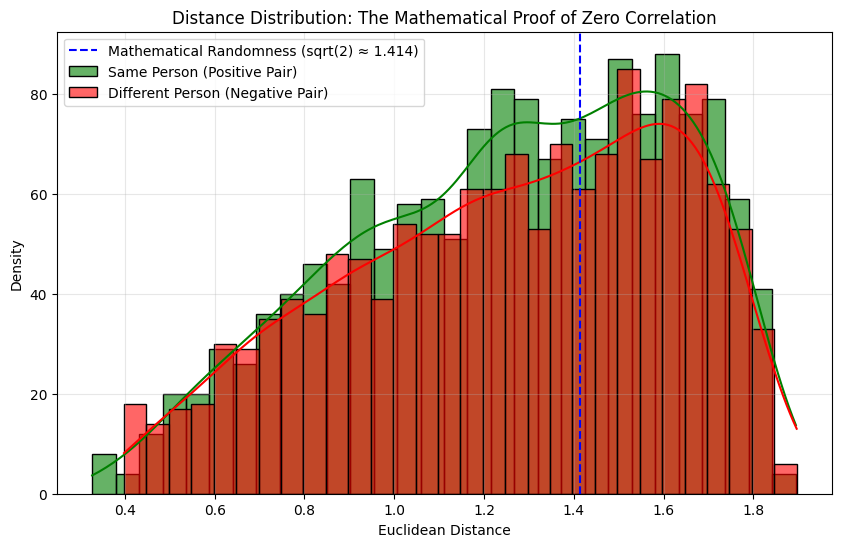

In [5]:
# ==========================================
# 5. VISUALIZATION & MATHEMATICAL PROOF
# ==========================================
model.eval()
distances = []
actual_labels = []

print("Calculating distances on the unseen test set...")
with torch.no_grad():
    for faces, fingers, labels in test_loader:
        faces, fingers, labels = faces.to(device), fingers.to(device), labels.cpu().numpy()
        
        face_emb, finger_emb = model(faces, fingers)
        dist = F.pairwise_distance(face_emb, finger_emb).cpu().numpy()
        
        distances.extend(dist)
        actual_labels.extend(labels)

distances = np.array(distances)
actual_labels = np.array(actual_labels)

plt.figure(figsize=(10, 6))
sns.histplot(distances[actual_labels == 1], color="green", label="Same Person (Positive Pair)", kde=True, bins=30, alpha=0.6)
sns.histplot(distances[actual_labels == 0], color="red", label="Different Person (Negative Pair)", kde=True, bins=30, alpha=0.6)

plt.axvline(x=np.sqrt(2), color='blue', linestyle='--', label='Mathematical Randomness (sqrt(2) ≈ 1.414)')
plt.title("Distance Distribution: The Mathematical Proof of Zero Correlation")
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Conclusion: Feature-Level Fusion is the Wrong Approach Here
This experiment perfectly demonstrates the concept of the **"Semantic Gap"**. You cannot force a neural network to create a shared embedding space if there are no shared features to extract in the first place.

**What is the correct approach for this dataset?**
Instead of trying to fuse the features at the extraction level (Metric Learning), multimodal biometric systems combining completely uncorrelated data must use **Score-Level Fusion**:
1. Train a Face Recognition model entirely independently.
2. Train a Fingerprint Verification model entirely independently.
3. Combine their final confidence scores (e.g., Face says 90% match, Fingerprint says 85% match -> Final Decision: Authenticated).

This notebook serves as a valuable negative result, proving the architectural limits of cross-modal contrastive learning on biologically uncorrelated data.